In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)


df_comp = pd.read_csv("./data_storage/spglobal_data/company.csv")
df_price = pd.read_csv('./data_storage/spglobal_data/company_price.csv')
df = pd.read_csv("./data_storage/portfolio_history.csv")


cash_flow = pd.read_csv('./data_storage/cash_flow.csv').set_index('transaction_date')
ex_rate = pd.read_csv('./data_storage/currency.csv')[['Unnamed: 0', 'KRWUSD']].ffill().rename(columns={'Unnamed: 0': 'date'})
ex_rate['date'] = pd.to_datetime(ex_rate['date'])
cash_flow.index.name = 'date'
cash_flow.index = pd.to_datetime(cash_flow.index)
cash_flow = cash_flow.groupby('date').sum()

map = df_comp[['tradingitemid', 'ticker_symbol']].set_index('tradingitemid').to_dict()['ticker_symbol']
start_date = df['date'].min()
end_date = df['date'].max()


In [2]:


df_price = pd.read_csv('./data_storage/spglobal_data/company_price.csv')

df_price['tickersymbol'] = df_price['tradingitemid'].map(map)
df_price = df_price.rename(columns={'pricingdate':'date'})
df_price= df_price[['date', 'tickersymbol', 'priceclose_raw']]


df_price = df_price.pivot(index='date', columns='tickersymbol', values='priceclose_raw').ffill()
df_price.index = pd.to_datetime(df_price.index)
full_range = pd.date_range(start=df_price.index.min(), end=df_price.index.max(), freq="D")
df_price = df_price.reindex(full_range).ffill()
df_price.index.name = "date"

df_price = pd.melt(df_price.reset_index(), id_vars=['date'], value_vars=df_price.columns, var_name='ticker', value_name='price_close')
df_price


,date,ticker,price_close
0,2019-01-02,A069500,26270.00
1,2019-01-03,A069500,26015.00
2,2019-01-04,A069500,26215.00
3,2019-01-05,A069500,26215.00
4,2019-01-06,A069500,26215.00
...,...,...,...
111820,2025-10-17,UAL,99.14
111821,2025-10-18,UAL,99.14
111822,2025-10-19,UAL,99.14
111823,2025-10-20,UAL,101.29


In [3]:

def expand_portfolio_to_daily(df, end_date=None, freq="D"):
    """
    Expand sparse portfolio snapshots to daily rows by duplicating each snapshot
    until the next snapshot date (exclusive). For the last snapshot, expand up to
    `end_date` (inclusive) if provided.
    """
    out = df.copy()

    # 1) normalize and keep original as snapshot_date
    out['date'] = pd.to_datetime(out['date']).dt.normalize()
    out = out.rename(columns={'date': 'snapshot_date'})

    # 2) compute next snapshot date (exclusive upper bound)
    snaps = pd.Index(sorted(out['snapshot_date'].unique()))
    next_map = {}
    for i, d in enumerate(snaps):
        if i + 1 < len(snaps):
            next_map[d] = snaps[i + 1]  # next snapshot (exclusive)
        else:
            if end_date is not None:
                next_map[d] = pd.to_datetime(end_date).normalize() + pd.Timedelta(days=1)
            else:
                next_map[d] = d + pd.Timedelta(days=1)  # only same day

    out['next_date'] = out['snapshot_date'].map(next_map)

    # 3) build per-row ranges on chosen frequency, inclusive start / exclusive end
    def _make_range(row):
        end_excl = row['next_date'] - pd.Timedelta(days=1)
        rng = pd.date_range(row['snapshot_date'], end_excl, freq=freq)
        # ensure at least one row even if freq skips the day (e.g., B on weekend)
        if len(rng) == 0:
            rng = pd.DatetimeIndex([row['snapshot_date']])
        return rng

    out['date'] = out.apply(_make_range, axis=1)

    # 4) explode to daily rows
    expanded = out.explode('date', ignore_index=True)

    # 5) tidy up — drop helper columns, sort
    expanded.drop(columns=['snapshot_date', 'next_date'], inplace=True)
    if 'ticker' in expanded.columns:
        expanded.sort_values(['date', 'ticker'], inplace=True, ignore_index=True)
    else:
        expanded.sort_values(['date'], inplace=True, ignore_index=True)

    return expanded

In [4]:
df = expand_portfolio_to_daily(df)
df = df[['date', 'ticker', 'type', 'market', 'amount','total_value']]

In [5]:
df_price

,date,ticker,price_close
0,2019-01-02,A069500,26270.00
1,2019-01-03,A069500,26015.00
2,2019-01-04,A069500,26215.00
3,2019-01-05,A069500,26215.00
4,2019-01-06,A069500,26215.00
...,...,...,...
111820,2025-10-17,UAL,99.14
111821,2025-10-18,UAL,99.14
111822,2025-10-19,UAL,99.14
111823,2025-10-20,UAL,101.29


In [6]:
new_df = df.merge(df_price[['date','ticker','price_close']], on=['date', 'ticker'], how='left')

new_df['market_value'] = new_df['price_close'] * new_df['amount']
new_df.loc[new_df['type'] == 'Cash', 'market_value'] = new_df.loc[new_df['type'] == 'Cash', 'total_value']
new_df.loc[new_df['type'] == 'Bond', 'market_value'] = new_df.loc[new_df['type'] == 'Bond', 'total_value']

new_df = new_df.merge(ex_rate, on='date', how='left')
new_df['market_value_won'] = new_df['market_value']
new_df.loc[new_df['market'] == 'US', 'market_value_won'] *= new_df.loc[new_df['market'] == 'US', 'KRWUSD'] 

In [7]:
ndf = new_df.groupby('date').sum()['market_value_won']
ndf

date
2020-03-05      811500.00
2020-03-06      811500.00
2020-03-07      811500.00
2020-03-08      811500.00
2020-03-09      811500.00
                 ...     
2025-09-25   298251535.84
2025-09-26   301686303.96
2025-09-27   301686303.96
2025-09-28   301686303.96
2025-09-29   300609621.95
Name: market_value_won, Length: 2035, dtype: float64

In [8]:
(df['total_value'].pct_change().loc['2020-04-01':] + 1).cumprod().to_csv('cumprod.csv')

/usr/local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


In [9]:
plt.figure(figsize=(12, 6))
plt.plot(ndf, linewidth=2)
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Return Value (KRW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('portfolio_value.png')
plt.close()

In [10]:
def get_daily_cum_return(market_value_s:pd.Series, cash_flow_s:pd.Series, sdate=None):    

    ms = market_value_s
    cs = cash_flow_s

    raw_pct_change = ms.pct_change()
 
    df = pd.concat([ms, cs], axis=1)
    df = df.reset_index()
    df.columns = ['date', 'market_value', 'cash_flow']
    
    df['total_value'] = df['market_value'] - df['cash_flow']
    df['pct_change'] = df['total_value'].pct_change()

    cs_dates = cs.index.tolist()

    raw_pct_change[raw_pct_change.index.isin(cs_dates)] = df.loc[df['date'].isin(cs_dates), 'pct_change']

    cum_return = (raw_pct_change+1).cumprod() -1
    
    return cum_return

In [11]:
market_value_s = ndf
cash_flow_s = cash_flow['transaction_amount']

ms = market_value_s
cs = cash_flow_s

raw_pct_change = ms.pct_change()

df = pd.concat([ms, cs], axis=1)
df = df.reset_index()
df.columns = ['date', 'market_value', 'cash_flow']

df['cash_flow'] = df['cash_flow'].fillna(0)
df['total_value'] = df['market_value'] - df['cash_flow']
df['pct_change'] = df['total_value'].pct_change()

cs_dates = cs.index.tolist()

raw_pct_change[raw_pct_change.index.isin(cs_dates)] = df.loc[df['date'].isin(cs_dates), 'pct_change']

cum_return = (raw_pct_change+1).cumprod() -1

#cum_return = get_daily_cum_return(market_value_s, cash_flow_s)

In [12]:
df.loc[df['date']=='2021-01-04']

,date,market_value,cash_flow,total_value,pct_change
305,2021-01-04,14502945.63,1810000.00,12692945.63,-0.03


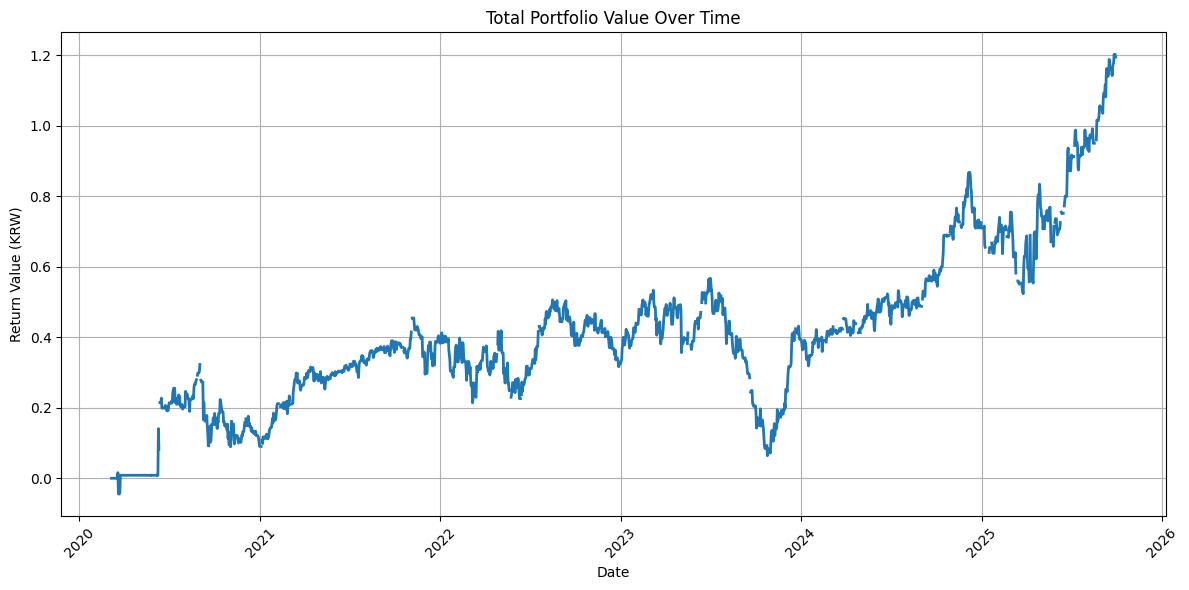

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(cum_return, linewidth=2)
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Return Value (KRW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('portfolio_.png')
plt.show()
plt.close()

cum_return.to_csv('my_return.csv')

In [14]:
new_df.loc[new_df['date']=='2023-10-01']

,date,ticker,type,market,amount,total_value,price_close,market_value,KRWUSD,market_value_won
14520,2023-10-01,AAL,Stock,US,35.00,582.00,12.81,448.35,1349.30,604958.66
14521,2023-10-01,AAPL,Stock,US,6.00,707.10,171.21,1027.26,1349.30,1386081.92
14522,2023-10-01,ALB,Stock,US,1.00,214.90,170.04,170.04,1349.30,229434.97
14523,2023-10-01,AMZN,Stock,US,9.00,1219.18,127.12,1144.08,1349.30,1543707.14
14524,2023-10-01,BA,Stock,US,10.00,1357.10,191.68,1916.80,1349.30,2586338.24
14525,2023-10-01,BAC,Stock,US,11.00,320.32,27.38,301.18,1349.30,406382.17
14526,2023-10-01,C,Stock,US,8.00,371.04,41.13,329.04,1349.30,443973.67
14527,2023-10-01,CCL,Stock,US,29.00,552.69,13.72,397.88,1349.30,536859.48
14528,2023-10-01,DAL,Stock,US,62.00,2186.97,37.00,2294.00,1349.30,3095294.20
14529,2023-10-01,GM,Stock,US,5.00,173.24,32.97,164.85,1349.30,222432.10


tdf.loc[tdf['ticker'] == 'T 1.625 11/15/50']